In [1]:
import numpy as np
import tensorflow as tf
import gpflow
import matplotlib.pyplot as plt
np.random.seed(1976)
tf.random.set_seed(1976)

2022-06-28 13:51:20.918930: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-28 13:51:20.918956: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from math import sin

In [3]:
def fe(x):
   
    return(6*x-2)*(6*x-2)*tf.sin(12*x-4)
def fc(x):
    return(1/2*fe(x)+10*(x-1/2)-5)

In [4]:

from trieste.data import Dataset
OBJECTIVE = "OBJECTIVE"
def observer_e(query_points_e):
    return {
        OBJECTIVE: Dataset(query_points_e, fe(query_points_e))
    }

2022-06-28 13:58:25.584119: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-28 13:58:25.584165: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (macaron): /proc/driver/nvidia/version does not exist


In [7]:
def observer_c(query_points_c ):
    return {
        OBJECTIVE: Dataset(query_points_c, fc(query_points_c))
    }

In [8]:
num_initial_points_e=4
num_initial_points_c=11

In [9]:
X_c=np.array([[0],[0.2],[0.4],[0.6],[0.7],[0.9],[1]])
X_e=np.array([[0],[0.4],[0.6],[1]])



In [10]:
initial_data_c = observer_c(X_c)
initial_data_e = observer_e(X_e)


In [11]:
L=np.arange(0,1,0.001)

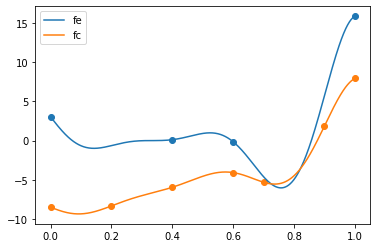

In [13]:
plt.plot(L,fe(L), label='fe')
plt.plot(L,fc(L), label='fc')
plt.scatter(initial_data_e[OBJECTIVE].query_points,initial_data_e[OBJECTIVE].observations)
plt.scatter(initial_data_c[OBJECTIVE].query_points,initial_data_c[OBJECTIVE].observations)
plt.legend()

In [14]:
## coarse model
k=gpflow.kernels.RBF(1)
theta2=gpflow.kernels.Constant()
k_c=k+theta2 
k_c


<gpflow.kernels.base.Sum object at 0x7f01a052f130>
╒═════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                        │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Sum.kernels[0].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[0].lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[1].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
╘═════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════╛

In [15]:
mean=tf.math.reduce_mean(initial_data_c[OBJECTIVE].observations[:])
mean_function=gpflow.mean_functions.Constant(mean)

model_c=gpflow.models.GPR((initial_data_c[OBJECTIVE].query_points[:], initial_data_c[OBJECTIVE].observations[:]),k_c,mean_function)

In [16]:
## finding hyperparameters


optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model_c.training_loss,variables=model_c.trainable_variables,options=dict(disp=True, maxiter=100),)


2022-06-28 14:00:22.065363: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.27953D+01    |proj g|=  3.26839D+01

At iterate    1    f=  5.36114D+01    |proj g|=  1.39644D+01

At iterate    2    f=  3.81202D+01    |proj g|=  5.91503D+00

At iterate    3    f=  3.19511D+01    |proj g|=  3.43711D+00

At iterate    4    f=  2.71637D+01    |proj g|=  1.91253D+00

At iterate    5    f=  2.45263D+01    |proj g|=  1.04197D+00

At iterate    6    f=  2.28819D+01    |proj g|=  5.67676D-01

At iterate    7    f=  2.21937D+01    |proj g|=  1.32254D+00

At iterate    8    f=  2.13882D+01    |proj g|=  5.95455D-01

At iterate    9    f=  2.09433D+01    |proj g|=  1.18778D-01

At iterate   10    f=  2.07487D+01    |proj g|=  8.76483D-02

At iterate   11    f=  2.05723D+01    |proj g|=  7.61620D-02

At iterate   12    f=  2.04055D+01    |proj g|=  1.23575D-01

At iterate   13    f=  2.0

 This problem is unconstrained.


      fun: 19.508987323988055
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.61667389e-004,  1.26471797e-006,  3.36234175e-008,
        5.82324085e-107, -7.47382671e-006])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 60
      nit: 53
     njev: 60
   status: 0
  success: True
        x: array([  -1.5062498 ,   43.13191352,  -13.85379269, -243.86254937,
         -2.48623732])


At iterate   53    f=  1.95090D+01    |proj g|=  1.61667D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     53     60      1     0     0   1.617D-04   1.951D+01
  F =   19.508987323988055     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [17]:
model_c

<gpflow.models.gpr.GPR object at 0x7f01a073e6b0>
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │        value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ GPR.mean_function.c                │ Parameter │ Identity         │         │ True        │ ()      │ float64 │ -2.48624     │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 43.1319      │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  0.200276    │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  9.62441e-07 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.likelihood.variance            │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │  1e-06       │
╘════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧══════════════╛

In [18]:
model_c.likelihood.variance

<Parameter: name=chain_of_shift_of_softplus, dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=1e-06>

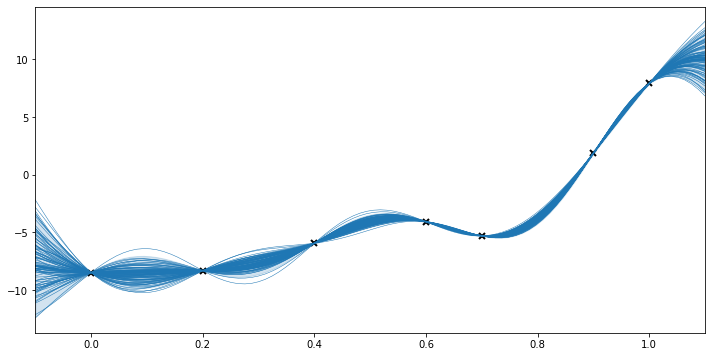

In [20]:
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)


## predict mean and variance of latent GP at test points
mean_c, var_c = model_c.predict_f(xx)

## generate 100 samples from posterior
samples = model_c.predict_f_samples(xx, 100) # shape (10, 100, 1)

## plot 
plt.figure(figsize=(12, 6))
plt.plot(initial_data_c[OBJECTIVE].query_points[:], initial_data_c[OBJECTIVE].observations[:], 'kx', mew=2)
plt.plot(xx, mean_c, 'C0', lw=2)
plt.fill_between(xx[:,0],
                 mean_c[:,0] - 1.96 * np.sqrt(var_c[:,0]),
                 mean_c[:,0] + 1.96 * np.sqrt(var_c[:,0]),
                 color='C0', alpha=0.2)

plt.plot(xx, samples[:, :, 0].T, 'C0', linewidth=.5)
plt.xlim(-0.1, 1.1);



In [21]:
## we fix the trained hyperparameters of the lowest model
gpflow.set_trainable(k_c.kernels, False)
## high fidelity model 
k=gpflow.kernels.RBF()
theta=gpflow.kernels.Constant()
k_e=k+theta
k_e

<gpflow.kernels.base.Sum object at 0x7f011f3c1a50>
╒═════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                        │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Sum.kernels[0].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[0].lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[1].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
╘═════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════╛

In [22]:
k_e.trainable_parameters

(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=1.0>,
 <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=1.0>,
 <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=1.0>)

In [23]:

mean=tf.math.reduce_mean(initial_data_e[OBJECTIVE].observations[:])
mean_function=gpflow.mean_functions.Constant(mean)
model_e=gpflow.models.GPR((initial_data_e[OBJECTIVE].query_points[:], initial_data_e[OBJECTIVE].observations[:]),k_e,mean_function)
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model_e.training_loss,variables=model_e.trainable_variables,options=dict(disp=True, maxiter=100),)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.79003D+01    |proj g|=  3.93739D+01

At iterate    1    f=  4.94546D+01    |proj g|=  1.78369D+01

At iterate    2    f=  3.69584D+01    |proj g|=  9.56043D+00

At iterate    3    f=  2.67594D+01    |proj g|=  4.06466D+00

At iterate    4    f=  2.06289D+01    |proj g|=  1.66538D+00

At iterate    5    f=  1.85729D+01    |proj g|=  1.06051D+00

At iterate    6    f=  1.62661D+01    |proj g|=  5.19354D-01

At iterate    7    f=  1.50538D+01    |proj g|=  2.95959D-01

At iterate    8    f=  1.39980D+01    |proj g|=  1.52918D-01

At iterate    9    f=  1.37129D+01    |proj g|=  7.85712D-01

At iterate   10    f=  1.34873D+01    |proj g|=  3.26523D-01

At iterate   11    f=  1.33080D+01    |proj g|=  1.15075D-01

At iterate   12    f=  1.32152D+01    |proj g|=  1.19554D-01

At iterate   13    f=  1.3

 This problem is unconstrained.


      fun: 12.84044930796454
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.81498725e-05,  5.74559533e-06,  2.46762120e-05,  4.38014560e-07,
       -1.67186043e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 49
      nit: 42
     njev: 49
   status: 0
  success: True
        x: array([ -1.46481196,  41.56391349,  -7.23779602, -10.44209563,
         6.00716878])


At iterate   42    f=  1.28404D+01    |proj g|=  7.81499D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     49      1     0     0   7.815D-05   1.284D+01
  F =   12.840449307964541     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


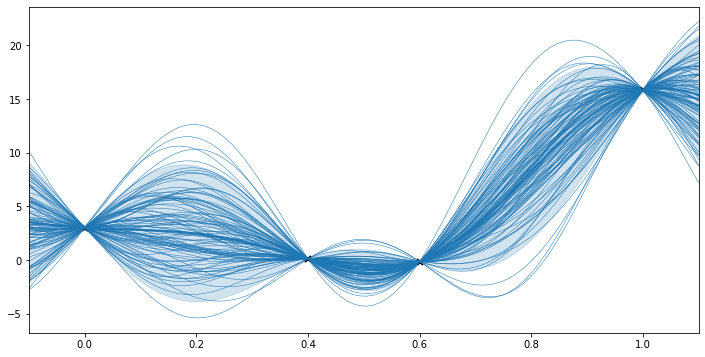

In [24]:
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)


## predict mean and variance of latent GP at test points
mean_e, var_e = model_e.predict_f(xx)


## generate 100 samples from posterior
samples = model_e.predict_f_samples(xx, 100)  # shape (10, 100, 1)

## plot 
plt.figure(figsize=(12, 6))
plt.plot(initial_data_e[OBJECTIVE].query_points[:], initial_data_e[OBJECTIVE].observations[:], 'kx', mew=2)
plt.plot(xx, mean_e, 'C0', lw=2)
plt.fill_between(xx[:,0],
                 mean_e[:,0] - 1.96 * np.sqrt(var_e[:,0]),
                 mean_e[:,0] + 1.96 * np.sqrt(var_e[:,0]),
                 color='C0', alpha=0.2)

plt.plot(xx, samples[:, :, 0].T, 'C0', linewidth=.5)
plt.xlim(-0.1, 1.1);


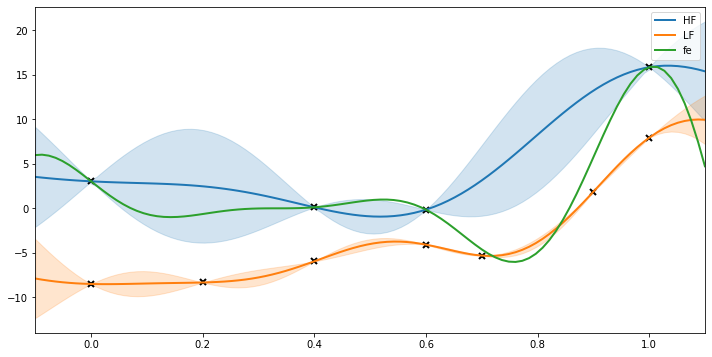

In [25]:

plt.figure(figsize=(12, 6))
plt.plot(initial_data_e[OBJECTIVE].query_points[:], initial_data_e[OBJECTIVE].observations[:], 'kx', mew=2)
plt.plot(initial_data_c[OBJECTIVE].query_points[:], initial_data_c[OBJECTIVE].observations[:], 'kx', mew=2)
plt.plot(xx, mean_e, 'C0', lw=2, label="HF")
plt.plot(xx, mean_c, 'C1', lw=2, label="LF")
plt.plot(xx, fe(xx), 'C2', lw=2, label="fe")

plt.fill_between(xx[:,0],
                 mean_e[:,0] - 1.96 * np.sqrt(var_e[:,0]),
                 mean_e[:,0] + 1.96 * np.sqrt(var_e[:,0]),
                 color='C0', alpha=0.2)
plt.fill_between(xx[:,0],
                 mean_c[:,0] - 1.96 * np.sqrt(var_c[:,0]),
                 mean_c[:,0] + 1.96 * np.sqrt(var_c[:,0]),
                 color='C1', alpha=0.2)


plt.xlim(-0.1, 1.1);
plt.legend()

# MF

In [26]:
X_e=initial_data_e[OBJECTIVE].query_points[:]
Y_e=initial_data_e[OBJECTIVE].observations[:]
Y_c,var_c=model_c.predict_f(X_e)
n=num_initial_points_e


In [27]:
### log-likelihood function
import math

def neg_log_likelihood(par, X_e,Y_e,Y_c):
    Ro,l,var,theta, sigma_epsilon=par 
    dist_X_e = (X_e - X_e.T)**2
    k = var*np.exp(-(1/(2*(l**2)))*dist_X_e)+theta
    n=len(X_e)
    return -(-n/2*np.log(2*np.pi)-1/2*np.log(np.linalg.det(k+(sigma_epsilon**2)*np.eye(n)))-1/2*np.dot(np.dot(( Y_e.numpy()-Ro*Y_c.numpy()).T,np.linalg.inv(k+(sigma_epsilon**2)*np.eye(n))),(Y_e.numpy()-Ro*Y_c.numpy())))




In [28]:
from scipy.optimize import minimize 
start =  [0.1,0.1, 33,0.1,0.1]
###adding constraints 

min=minimize(neg_log_likelihood, start, args=(X_e,Y_e,Y_c), bounds=[(-np.inf,np.inf),(0e-4,2),(0,30**2),(-np.inf,np.inf),(0,1000)],method='L-BFGS-B',options = {'disp':True,'maxiter':1000})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43091D+01    |proj g|=  2.48293D+00

At iterate    1    f=  1.24221D+01    |proj g|=  1.34742D+00

At iterate    2    f=  1.23798D+01    |proj g|=  1.39818D+00

At iterate    3    f=  1.21827D+01    |proj g|=  3.85978D-01

At iterate    4    f=  1.21584D+01    |proj g|=  6.99227D-01

At iterate    5    f=  1.21436D+01    |proj g|=  4.03408D-01

At iterate    6    f=  1.21290D+01    |proj g|=  4.94365D-01

At iterate    7    f=  1.21268D+01    |proj g|=  3.03214D-01

At iterate    8    f=  1.21234D+01    |proj g|=  1.22875D-01

At iterate    9    f=  1.21215D+01    |proj g|=  2.27990D-01

At iterate   10    f=  1.21020D+01    |proj g|=  9.86475D-01

At iterate   11    f=  1.20651D+01    |proj g|=  1.48292D+00

At iterate   12    f=  1.19658D+01    |proj g|=  1.49938D+00

At iterate   13    f=  1.1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   29    f=  8.78634D+00    |proj g|=  2.74436D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     58     29     0     1   2.744D+00   8.786D+00
  F =   8.7863395998338927     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [29]:

min.x
##Ro,l, variance, theta,  bruit 

array([  1.89492937,   1.68962885, 217.77876817, 314.32843553,
         0.        ])

In [30]:
## building the second kernel kernel C_e(Theta_e)

k=gpflow.kernels.RBF(min.x[2],min.x[1])
theta=gpflow.kernels.Constant(min.x[3])
k_MF=k+theta


In [31]:
k_MF

<gpflow.kernels.base.Sum object at 0x7f011f1fbe50>
╒═════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                        │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ Sum.kernels[0].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 217.779   │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ Sum.kernels[0].lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │   1.68963 │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ Sum.kernels[1].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 314.328   │
╘═════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═══════════╛

In [34]:
## noise variance

sigma_epsilon=min.x[4]


## vecteur de correlation

def K(x):
    l=len(x)
    K=np.zeros((n,l))
    for i in range(n):
        K[i,:]=k_MF(x,initial_data_e[OBJECTIVE].query_points[i])
    return K
## coefficient de correlation
def k(x):
    l=len(x)
    k=np.zeros((1,l))
    k[:]=np.array(k_MF(x)).diagonal()
    return k



def f_hat(x) :
    
    Y_e=initial_data_e[OBJECTIVE].observations[:]
    Y_c,var=model_c.predict_f(X_e)
    mean_c, var_c= model_c.predict_f(x)
    
    return min.x[0]*mean_c+np.dot(np.dot(K(x).T, np.linalg.inv(k_MF(X_e)+(sigma_epsilon**2)*np.eye(n))),Y_e-min.x[0]*Y_c)
    #return  f_hat
def sigma_square_hat(x):
    mean_c, var_c= model_c.predict_f(x)
    
    
    return pow(min.x[0],2)*var_c+sigma_epsilon**2+k(x).reshape(len(x),1)-np.dot(np.dot(K(x).T, np.linalg.inv(k_MF(X_e)+(sigma_epsilon**2)*np.eye(n))),K(x)).diagonal().reshape(len(x),1)
                                 
                                 

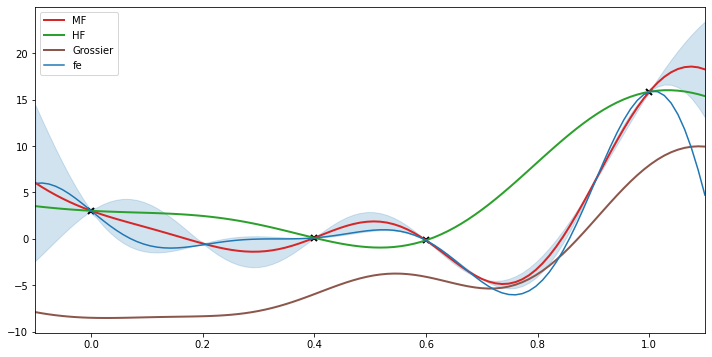

In [35]:

## plot 
plt.figure(figsize=(12, 6))
plt.plot(initial_data_e[OBJECTIVE].query_points[:], initial_data_e[OBJECTIVE].observations[:], 'kx', mew=2)
plt.plot(xx, f_hat(xx), 'C3', label='MF',lw=2)
plt.plot(xx, mean_e, 'C2', label='HF',lw=2)
plt.plot(xx, mean_c, 'C5', label='Grossier',lw=2)
plt.plot(xx,fe(xx),'C0', label="fe")

plt.fill_between(xx[:,0],
                f_hat(xx)[:,0] - 1.96 * np.sqrt(sigma_square_hat(xx)[:,0]),
                f_hat(xx)[:,0] + 1.96 * np.sqrt(sigma_square_hat(xx)[:,0]),
                color='C0', alpha=0.2)

plt.legend()

plt.xlim(-0.1, 1.1);